### 1D advection Level Set Method with reinitialisation

In [1]:
using Plots
using LinearAlgebra

##### Functions

In [2]:
# Initalisation phi
function init(x)
    -1. + x^2
end

# Forcing term as sin(t)
function init2(x)
    4.0 * sin(4. *x*pi)
end

# Periodic boundary conditions
function periodic(phi,i)
    [phi[i,end]; phi[i,:]; phi[i,1]]
end

# VOF upwind flux computation 
function flux(phibc,i,nx,u)
    if typeof(u) == Float64
        F[i,:] =   0.5*u*(phibc[i,2:nx+2] + phibc[i,1:nx+1])- 0.5*abs(u)*( phibc[i,2:nx+2] - phibc[i,1:nx+1]);
        R[i,:] = F[i,2:nx+1] - F[i,1:nx];
    elseif typeof(u) == Array{Float64,1}
        F[i,:] =   0.5*u[i+1]*(phibc[i,2:nx+2] + phibc[i,1:nx+1])- 0.5*abs(u[i+1])*( phibc[i,2:nx+2] - phibc[i,1:nx+1]);
        R[i,:] = F[i,2:nx+1] - F[i,1:nx];
    end
end

# Sign fuction used for reinitialisation of level set function
function sign1(x,dx)
    x/sqrt(x.^2 +dx^2)
end

sign1 (generic function with 1 method)

##### Parameters and initialisation

In [3]:
nt = 1000
nx = 100
Tmax = 5.
Xmax = 2.
dt = Tmax/nt
dx = 2*Xmax/nx
x = -Xmax:dx:Xmax;

xmid = 0.5*(x[1:nx] + x[2:nx+1])

sol = zeros(nt+1,nx)
phi = zeros(nt+1,nx)
phi2 = zeros(nt+1,nx)
phibc = zeros(nt,nx+2) # function without reinitialisation
phibc2 = zeros(nt,nx+2)# function with reinitialisation
phi0 = zeros(1,nx)
err = zeros(1,nt)
F = zeros(nt,nx + 1)
R = zeros(nt,nx)
phi[1,:] = init.(xmid);
phi2[1,:] = init.(xmid);
tspawn = 0:dt:Tmax;
u = init2.(tspawn);

##### Main loop

In [4]:
for i = 1:nt
    # Periodic BC imposed at each time step
    phibc[i,:] = periodic(phi,i) 
    phibc2[i,:] = periodic(phi2,i) 
    
    # Update the level set function
    phi[i+1,:] = phi[i,:] - (dt/dx)*flux(phibc,i,nx,u);
    phi2[i+1,:] = phi2[i,:] - (dt/dx)*flux(phibc2,i,nx,u);
    
    # For phi2 we try to reinitialise the level set function at each time step
    # grad(Phi)| needs to be normalised to 1
    # We iterate over a non-physical time step until "equilibrium" is reached for :
    # d(phi)/dt = sign(phi) * (1. - |grad(Phi)|)
    # from MENARD, 2007 chap 2
    a = sign1.(phi2[i+1,:],dx)*(1. - norm(flux(phibc2,i,nx,1.)))
    for j = 1:300
        if norm(a) > 0.00001
            phi2[i+1,:] = phi2[i+1,:] + dt*a
            phibc2[i,:] = periodic(phi2,i)
            a = sign1.(phi2[i+1,:],dx)*(1. - norm(flux(phibc2,i,nx,1.)))
        end
    end
    
end

##### Post-processing

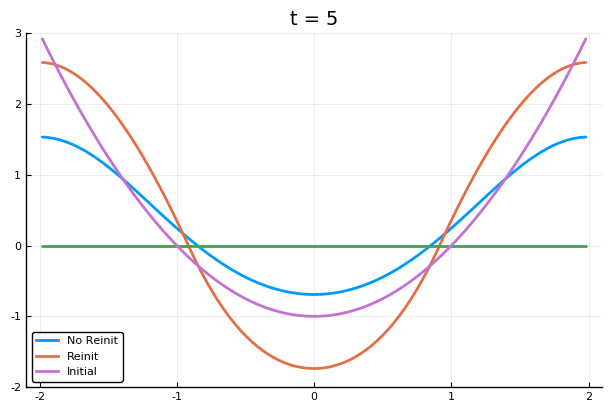

In [18]:
# The intersection of phi with the x axis represents the 1D interface.
# phi < 0 inside
# phi > 0 outside
# Non-reinitialised and reinitialised solutions are plotted for a sin(t) forcing term
# Exibits the numerical diffusion of the first order differencing scheme.

#anim = @animate for i=1:500
    #plot(xmid,[phi[i,:],phi2[i,:],phi0[1,:],phi[1,:]], ylims = (-2,3), label=["No Reinit" "Reinit" "" "Initial" ],lw=2)
#end
#gif(anim, "/Users/tomas/PhD/2019-2020/julia/JuLSM/1D-LSM-sin.gif", fps = 10);

plot(xmid,[phi[end,:],phi2[end,:],phi0[1,:],phi[1,:]], ylims = (-2,3), label=["No Reinit" "Reinit" "" "Initial" ],title = "t = 5",lw=2)
savefig("/Users/tomas/PhD/2019-2020/julia/JuLSM/Phi1D_t5.png")